In [ ]:
# default_exp core

# Calibrate

> Calibration for the Open Source DIY Hyperspectral Imager

In [ ]:
#hide
from nbdev.showdoc import *

## Common Format
First, we convert all calibration files to a common format (HDF5). Numpy arrays inside this file can be accessed like a dictionary.

`wavesoln.npz` contains `wavecal` and `newwave`.

File has entries: ['newwave', 'wavecal']


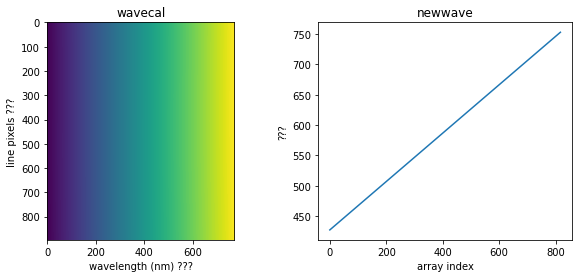

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

npzfile = np.load("cal_files/wavesoln.npz")
wavecal = npzfile["wavecal"]
newwave = npzfile["newwave"]

import h5py
with h5py.File("cal_files/wave_soln.hdf5", "w") as f:
    dset = f.create_dataset("wavecal",shape=wavecal.shape,dtype=np.float64)
    dset[...] = wavecal
    dset2 = f.create_dataset("newwave",shape=newwave.shape,dtype=np.float64)
    dset2[...] = newwave

# check if we can open the HDF5 files
with h5py.File("cal_files/wave_soln.hdf5", "r") as f:
    print(f'File has entries: {list(f.keys())}')

    plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    plt.subplot(1,2,1); plt.title('wavecal')
    plt.imshow(f['wavecal'])
    plt.xlabel('wavelength (nm) ???'); plt.ylabel('line pixels ???')
    

    plt.subplot(1,2,2); plt.title('newwave')
    plt.plot(newwave)
    plt.xlabel('array index'); plt.ylabel('???')

`arc.fits` contains `hdulist[0].data` which is called `arcimg`. `hdulist` has length 1. 

File has entries: ['arc_img']


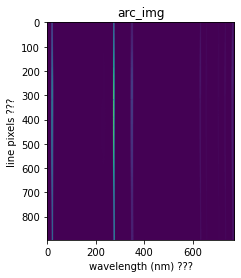

In [ ]:

from astropy.io import fits as fitsio
hdulist = fitsio.open("cal_files/arc.fits")
arcimg = np.rot90(hdulist[0].data, -1)

import h5py
with h5py.File("cal_files/arc.hdf5", "w") as f:
    dset = f.create_dataset("arc_img",shape=arcimg.shape,dtype=np.float64)
    dset[...] = arcimg


# check if we can open the HDF5 files
with h5py.File("cal_files/arc.hdf5", "r") as f:
    print(f'File has entries: {list(f.keys())}')
    
    plt.title('arc_img')
    plt.imshow(f['arc_img'])
    plt.xlabel('wavelength (nm) ???'); plt.ylabel('line pixels ???')

`hgar_linelist_cfht.mat` contains `#refs#`, `Species`, and `wavelength`. I don't know how to deal with `#refs#` and `Species`. 

File has entries: ['#refs#', 'Species', 'wavelength']


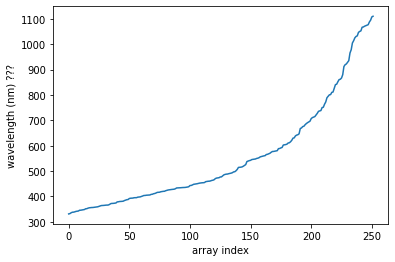

In [ ]:

with h5py.File('cal_files/hgar_linelist_cfht.mat','r') as f:
    print(f'File has entries: {list(f.keys())}')

    with h5py.File('cal_files/HgAr_lines.hdf5','w') as f2:
        wavelength = f.get('wavelength')[0,:] # original shape is (1,252)
        dset = f2.create_dataset("wavelength",shape=wavelength.shape,dtype=np.float64)
        dset[...] = wavelength

with h5py.File('cal_files/HgAr_lines.hdf5','r') as f:
        plt.plot(np.array(f['wavelength'])/10)
        plt.xlabel('array index')
        plt.ylabel('wavelength (nm) ???')

  #data = np.array( f.get('hypercube') )

## The Calibration Module

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate
from fastprogress.fastprogress import master_bar, progress_bar
from tqdm import tqdm


def NGaussFunc(x, *params):  # x0 pk width
    y = np.zeros_like(x)
    for i in range(0, len(params) - 1, 3):
        ctr = params[i]
        amp = params[i + 1]
        wid = params[i + 2]
        y = y + amp * np.exp(-((x - ctr) / wid) ** 2)
    return y + params[-1]


def linerise_wavelength(rawimagedata, wavecalfile="cal_files/wavesoln.npz"):
    npzfile = np.load(wavecalfile)
    wavecal = npzfile["wavecal"]
    newwave = npzfile["newwave"]

    # # min and max wave in all cols.
    # minwave = wavecal.min(axis=1).max()
    # maxwave = wavecal.max(axis=1).min()
    # minwavedelta = np.diff(wavecal, axis=1).min()

    # newwave = np.arange(minwave, maxwave, minwavedelta)

    interpimg = np.zeros((wavecal.shape[0], newwave.shape[0]))

    for col in range(0, wavecal.shape[0]):
        f = interpolate.interp1d(wavecal[col, :], rawimagedata[col, :])
        interpimg[col, :] = f(newwave)

    return interpimg


def fit_arc_lines(arcimg, spatial_col_skip=1, wavecalfile=""):
    arcimg = arcimg * 1.0 / np.max(arcimg, axis=1)[:, None]
    spatialaxis = np.arange(0, arcimg.shape[0])
    waveaxis = np.arange(0, arcimg.shape[1])

    arcgausfits = np.zeros((len(range(1, arcimg.shape[0], spatial_col_skip)) + 1, 28))

    spec = arcimg[0, :]
    peaks, properties = find_peaks(spec, height=0.01, width=1.5, prominence=0.01)

    y0 = np.zeros((peaks.size * 3))
    y0[0::3] = peaks
    y0[1::3] = properties["peak_heights"]
    y0[2::3] = properties["widths"] * 0.5
    y0 = np.append(y0, 0.02)

    arcgausfits[0, :], pcov = curve_fit(NGaussFunc, waveaxis, spec, p0=y0)
    i = 0
    print("Fitting Arc Lines in each col...")
    for col in tqdm(range(1, arcimg.shape[0], spatial_col_skip)):
        i += 1
        spec = arcimg[col, :]
        y0 = arcgausfits[i - 1, :]
        arcgausfits[i, :], pcov = curve_fit(NGaussFunc, waveaxis, spec, p0=y0)

    pos = arcgausfits[:, range(0, arcgausfits.shape[1] - 1, 3)]
    peakheight = arcgausfits[:, range(0, arcgausfits.shape[1] - 1, 3)]
    width = arcgausfits[:, range(2, arcgausfits.shape[1] - 1, 3)]

    smoothed_pos = np.zeros_like(pos)

    for row in tqdm(range(0, pos.shape[1])):
        smoothed_pos[:, row] = savgol_filter(pos[:, row], 21, 3)

    spectral_lines = (
        np.asarray(
            [
                4358.328,
                5460.735,
                5769.598,
                5790.663,
                6965.4307,
                7067.2175,
                7272.9359,
                7383.9805,
                7503.8691,
            ]
        )
        / 10
    )

    wavecal = np.zeros((smoothed_pos.shape[0], waveaxis.shape[0]))
    p = []
    for i in range(0, smoothed_pos.shape[0]):
        z = np.polyfit(smoothed_pos[i, :], spectral_lines, 4)
        p.append(np.poly1d(z))
        wavecal[i, :] = p[-1](waveaxis)

    minwave = wavecal.min(axis=1).max()
    maxwave = wavecal.max(axis=1).min()
    minwavedelta = np.diff(wavecal, axis=1).min()

    newwave = np.arange(minwave, maxwave, minwavedelta)

    interpimg = np.zeros((wavecal.shape[0], newwave.shape[0]))

    for col in range(0, wavecal.shape[0]):
        f = interpolate.interp1d(wavecal[col, :], arcimg[col, :])
    interpimg[col, :] = f(newwave)

    result = {
        "wavecal": wavecal,
        "pos": pos,
        "peakheight": peakheight,
        "width": width,
        "smoothed_pos": smoothed_pos,
        "newwave": newwave,
    }
    if len(wavecalfile):
        np.savez(wavecalfile, **result)

    return result

"""
if __name__ == "__main__":
    hdulist = fitsio.open("cal_files/arc.fits")
    arcimg = np.rot90(hdulist[0].data, -1)
    result = fit_arc_lines(arcimg)
    for key, value in result.items():
        print(key, " : ...")
    for key, value in result.items():
        print(key, " : ...")
"""